In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test


train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:

#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 5s 103ms/step - loss: 0.0486 - val_loss: 0.0229
Epoch 2/100
21/21 [==============================] - 2s 90ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 3/100
21/21 [==============================] - 2s 105ms/step - loss: 0.0013 - val_loss: 5.3063e-05
Epoch 4/100
21/21 [==============================] - 2s 109ms/step - loss: 4.5747e-04 - val_loss: 8.2113e-05
Epoch 5/100
21/21 [==============================] - 2s 107ms/step - loss: 3.8510e-04 - val_loss: 4.5642e-05
Epoch 6/100
21/21 [==============================] - 1s 66ms/step - loss: 3.5591e-04 - val_loss: 4.5552e-05
Epoch 7/100
21/21 [==============================] - 1s 66ms/step - loss: 3.3881e-04 - val_loss: 4.8257e-05
Epoch 8/100
21/21 [==============================] - 1s 69ms/step - loss: 3.2824e-04 - val_loss: 4.3689e-05
Epoch 9/100
21/21 [==============================] - 1s 58ms/step - loss: 3.1570e-04 - val_loss: 4.6886e-05
Epoch 10/100
21/21 [========================

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 11ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16232.372146349711


In [15]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99955465776611
Testing MAE: 16166.535866730108


In [16]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.0502786710858345], [0.05069807916879654], [0.051115185022354126], [0.0515427328646183], [0.05198320001363754], [0.05243595689535141], [0.05289989337325096], [0.05337390676140785], [0.053857095539569855], [0.054348647594451904], [0.054847896099090576], [0.055354297161102295], [0.05586739256978035], [0.056386757642030716], [0.05691211670637131], [0.05744316428899765], [0.05797969177365303], [0.058521516621112823], [0.05906844884157181], [0.05962039902806282], [0.06017724797129631], [0.06073892489075661], [0.06130532547831535], [0.061876434832811356], [0.062452204525470734], [0.0630325973033905], [0.06361759454011917], [0.06420720368623734], [0.06480138003826141], [0.06540016084909439], [0.06600355356931686], [0.06661154329776764], [0.0672241598367691], [0.06784141808748245], [0.06846334785223007], [0.06908997148275375], [0.0697212964296341], [0.07035735249519348], [0.07099820673465729], [0.07164385914802551], [0.07229434698820114], [0.07294971495866776], [0.07361000031232834], [0.074

In [17]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[14378.68335488],
       [14413.12346902],
       [14447.3745333 ],
       [14482.48305191],
       [14518.65245232],
       [14555.83103642],
       [14593.92764424],
       [14632.85172762],
       [14672.52925733],
       [14712.89354587],
       [14753.88983607],
       [14795.47346568],
       [14837.60680826],
       [14880.25499053],
       [14923.39537546],
       [14967.00287876],
       [15011.06036969],
       [15055.55285886],
       [15100.46474507],
       [15145.78868659],
       [15191.51489441],
       [15237.63755633],
       [15284.14810698],
       [15331.04532273],
       [15378.32522681],
       [15425.98476017],
       [15474.02239326],
       [15522.4387379 ],
       [15571.23012322],
       [15620.39960828],
       [15669.9478049 ],
       [15719.87348944],
       [15770.17910916],
       [15820.86588767],
       [15871.93627223],
       [15923.39209828],
       [15975.23397762],
       [16027.4643575 ],
       [16080.08874422],
       [16133.1071378 ],


In [18]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [19]:
print(y_pred_with_test_data.shape)
test_data.shape

(260,)


(160, 1)

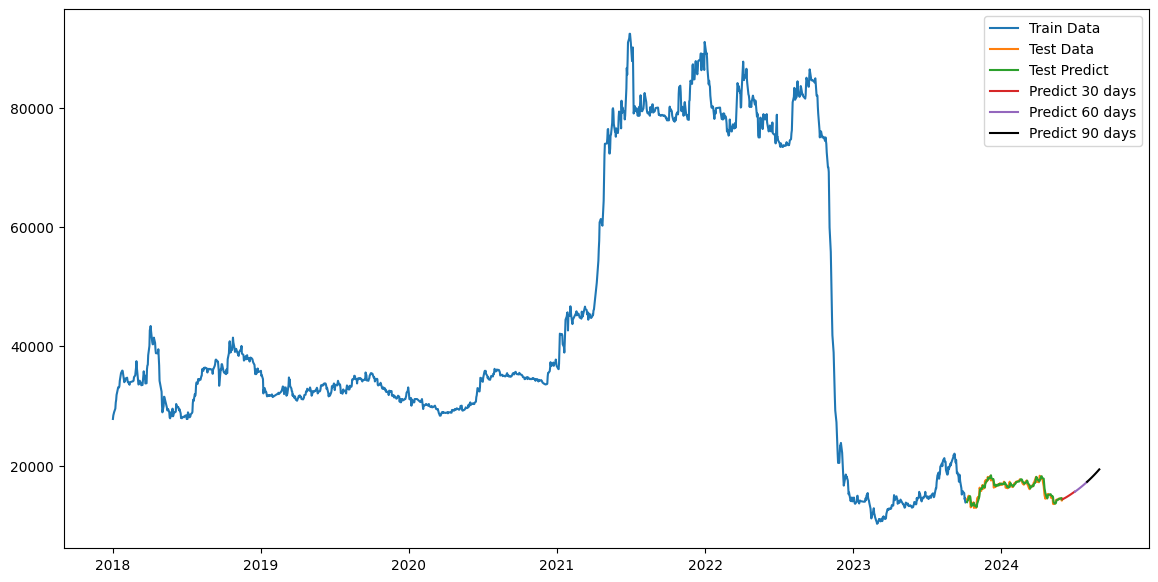

In [21]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()